## Import dependencies

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import warnings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('/content/LoanDataRiskAnalysis.csv')

Data Preprocessing steps

In [5]:
# Preprocessing
features = data.drop(columns=['PreviousLoanDefaults', 'ApplicationDate'])

# Adjust target column name
target = data['PreviousLoanDefaults']


Encode categorical values

In [6]:
features = pd.get_dummies(features)  # Encode categorical variables

Scale the data

In [7]:
scaler = StandardScaler()
features = scaler.fit_transform(features)

Train and Test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

Model Benchmarking

In [10]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Support Vector Machines": SVC(probability=True, random_state=42),
    "KNeighborsClassifier": KNeighborsClassifier(n_neighbors=5)
}

Benchmarke the models

In [11]:
# Benchmark each model
results = []

for name, model in models.items():
    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Evaluate
    accuracy = model.score(X_test, y_test)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    # Save results
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "ROC-AUC": roc_auc
    })
    print(f"--- {name} ---")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC: {roc_auc:.4f}" if roc_auc else "ROC-AUC: Not Available")
    print()

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1103
           1       0.94      0.74      0.83       147

    accuracy                           0.96      1250
   macro avg       0.95      0.87      0.90      1250
weighted avg       0.96      0.96      0.96      1250

ROC-AUC: 0.9860

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1103
           1       0.00      0.00      0.00       147

    accuracy                           0.88      1250
   macro avg       0.44      0.50      0.47      1250
weighted avg       0.78      0.88      0.83      1250

ROC-AUC: 0.8270

--- XGBoost ---
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1103
           1       0.96      0.65      0.77       147

    accuracy                           0.96      1250
   macro avg       0.96     

In [12]:
# Create a results DataFrame
results_df = pd.DataFrame(results)
print(results_df)

                     Model  Accuracy   ROC-AUC
0      Logistic Regression    0.9640  0.985963
1            Random Forest    0.8824  0.826962
2                  XGBoost    0.9552  0.990151
3  Support Vector Machines    0.8888  0.976912
4     KNeighborsClassifier    0.8776  0.539885


ROC Curve

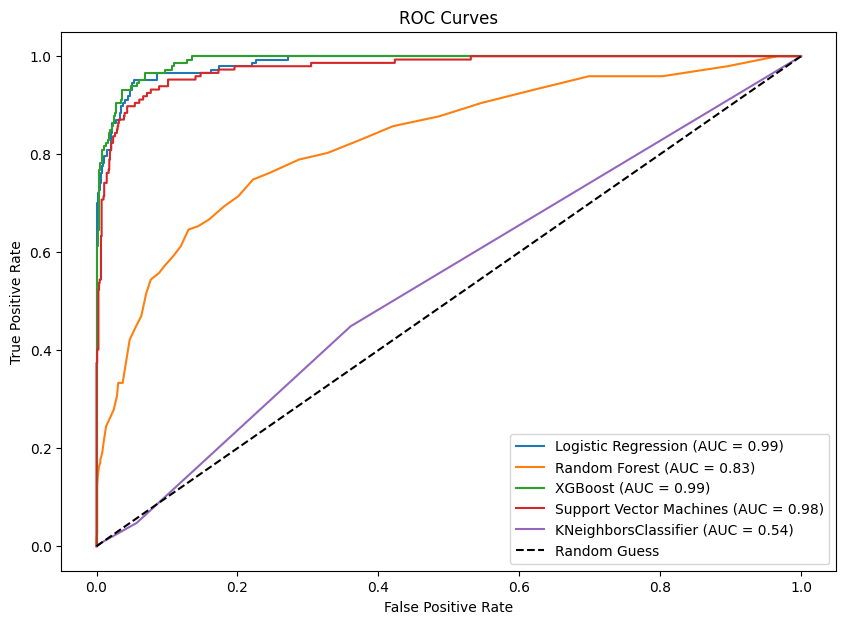

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 7))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


After the results currenlty I am choosing XGboost (I want to make my life harder Logistic regression is a better choice and easier to implement)

I will create a synthetic dataset to check my models predictions

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# Set a random seed for reproducibility
np.random.seed(42)

# I want the data for 100 clients
n_clients = 100

data = {
    "Age": np.random.randint(18, 90, n_clients),  # Client ages
    "AnnualIncome": np.random.randint(20000, 200000, n_clients),  # Annual income
    "DebtToIncomeRatio": np.random.uniform(0.1, 1.0, n_clients),  # Debt-to-income ratio
    "LoanAmount": np.random.randint(5000, 500000, n_clients),  # Loan amount
    "CreditScore": np.random.randint(300, 850, n_clients),  # Credit score
    "PreviousLoanDefaults": np.random.choice([0, 1], n_clients, p=[0.8, 0.2]),  # Default history
    "BankruptcyHistory": np.random.choice([0, 1], n_clients, p=[0.9, 0.1]),  # Bankruptcy history
    "PaymentHistory": np.random.uniform(0.5, 1.0, n_clients),  # Payment history score (normalized)
}

In [16]:
#Default risk (synthetic relationship)
data["DefaultRisk"] = (
    (data["DebtToIncomeRatio"] > 0.6) |
    (data["CreditScore"] < 600) |
    (data["PreviousLoanDefaults"] == 1)
).astype(int)

In [17]:
# Convert to DataFrame
df = pd.DataFrame(data)

In [18]:
X = df.drop(columns=["DefaultRisk"])
y = df["DefaultRisk"]

In [19]:
# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.90      1.00      0.95        18

    accuracy                           0.90        20
   macro avg       0.45      0.50      0.47        20
weighted avg       0.81      0.90      0.85        20

ROC-AUC Score: 0.8056


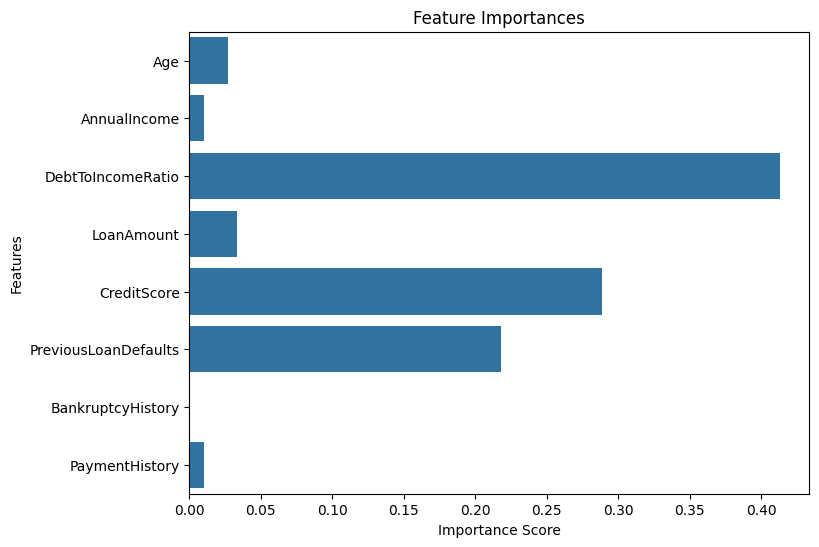


Sample Predictions:
        Age  AnnualIncome  DebtToIncomeRatio  LoanAmount  CreditScore  \
0 -1.278934     -0.958681           1.483010    0.721930    -0.647827   
1 -1.370713      0.902030           0.432987    1.156653     1.365884   
2 -0.452927     -0.658704           0.676506    1.527732     1.672318   
3  0.373080      0.581929           0.095565   -1.253547     0.853075   
4  1.612090     -1.095547          -1.201721    0.311702    -0.078735   

   PreviousLoanDefaults  BankruptcyHistory  PaymentHistory  DefaultRisk  \
0             -0.561951          -0.252646       -0.200509            1   
1             -0.561951          -0.252646       -1.595192            1   
2             -0.561951          -0.252646        1.578994            1   
3             -0.561951          -0.252646       -0.993520            0   
4             -0.561951           3.958114       -1.747955            1   

   PredictedRisk  PredictionProbability  
0              1               0.994053  
1    

In [35]:
# Train XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

#Evaluate the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Feature importance
feature_importances = model.feature_importances_
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importances, y=X.columns)
plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

# Predictions summary
df_test = pd.DataFrame(X_test, columns=X.columns)
df_test["DefaultRisk"] = y_test.values
df_test["PredictedRisk"] = y_pred
df_test["PredictionProbability"] = y_prob
print("\nSample Predictions:")
print(df_test.head())

Evaluate the Model